In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import yfinance as yf
import sqlite3
import matplotlib.pyplot as plt
import tkinter as tk
import tkinter.messagebox

import os
import seaborn as sns
import random
import mplfinance as mpf

pip install selenium


pip install yfinance

pip install mplfinance

In [2]:
api_url='https://tw.stock.yahoo.com/h/kimosel.php?tse=1&cat=%A5b%BE%C9%C5%E9&form=menu&form_id=stock_id&form_name=stock_name&domain=0'
def stocktitle(api_url):
    data=[]
    for i in range(2):
        form_data={
            'tse': f'{i+1}',
            'cat': '(unable to decode value)',
            'form': 'menu',
            'form_id': 'stock_id',
            'form_name': 'stock_name',
            'domain': '0'
        }
        resp=requests.post(api_url,data=form_data)
        soup=BeautifulSoup(resp.text,'lxml')
        a=soup.find_all('a')
        data.append([i.text.strip() for i in a])
    return data
data=stocktitle(api_url)     
data[0].remove('上櫃')
data[0].remove('詳細說明')
data[1].remove('上市')
data[1].remove('詳細說明')
data
datas=[]

for i in range(2):
    for stock in data[i]:
        try:
            form_data={
                    'tse': f'{i+1}',
                    'cat': f'{stock}',
                    'form': 'menu',
                    'form_id': 'stock_id',
                    'form_name': 'stock_name',
                    'domain': '0'
                }
            resp=requests.post(api_url,data=form_data)
            soup=BeautifulSoup(resp.text,'lxml')
        except:
            pass
        [datas.append(a.text.strip()) for a in soup.find_all('a')]
datas=list(set(datas))
title=stocktitle(api_url)
df_stockname=pd.DataFrame([i.split(' ')[:2] for i in datas],columns=['symbol','name'])
### 建立資料庫
try:
    con=sqlite3.connect('stock.db')
    cur=con.cursor()
    sqlstr='''
    create table if not exists stock(
        symbol varchar(50) PRIMARY KEY,
        name test
    );
    '''
    cur.execute(sqlstr)
    con.commit()
    con=sqlite3.connect('stock.db')
    df_stockname.to_sql('stock',con,if_exists='append',index=False)
    con.close()
except:
    print('已有股票資料庫')
con=sqlite3.connect('stock.db')
cur = con.cursor()
datas=cur.execute("SELECT * FROM stock")
datas=[data for data in datas]
df_stockname=pd.DataFrame(datas,columns=['symbol','name'])
print(df_stockname)
con.close()

已有股票資料庫
       symbol          name
0                      None
1      055397     裕民凱基17購02
2      731397     茂迪元大21購01
3      048212  T50反1元富17購02
4      051033    同欣電第一1B購01
...       ...           ...
15635  729788     瑞基元大1A購01
15636  056348     康普凱基18購02
15637  054005     康普兆豐18購01
15638  729902     網家凱基18購02
15639  055903    台勝科元大17購02

[15640 rows x 2 columns]


In [3]:
def getSoupWithChrome(url,path='c:/webdriver/chromedriver',hide=False):  
    option=webdriver.ChromeOptions()     
    if hide:        
        option.add_argument('--headless') 

    try:
        chrome=webdriver.Chrome(path,options=option)
        chrome.implicitly_wait(10)
        chrome.get(url)        
    except:
        return 'get webdriver error.'
     
    soup=None
    if chrome!=None:
        soup=BeautifulSoup(chrome.page_source,'lxml')    
        chrome.quit()
    return soup  

In [4]:
soup=getSoupWithChrome('https://tw.stock.yahoo.com/rank/volume/',path='c:/webdriver/chromedriver',hide=False)


C:\Users\swill\AppData\Local\Temp\ipykernel_15768\4024124112.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  chrome=webdriver.Chrome(path,options=option)


In [5]:
def stock_top(number=10):
    soup=getSoupWithChrome('https://tw.stock.yahoo.com/rank/volume/',path='c:/webdriver/chromedriver',hide=True)
    top100_html=[i.text.strip() for i in soup.find(class_="M(0) P(0) List(n)").find_all('div')]
    top100=[]
    for i in range(len(top100_html)):
        if (i%17==6) | (i%17==7):
            top100.append(top100_html[i])
    df_top100=pd.DataFrame(np.array(top100).reshape(int(len(top100)/2),2))
    
    return df_top100[:number]
stock_top(number=10)

C:\Users\swill\AppData\Local\Temp\ipykernel_15768\4024124112.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  chrome=webdriver.Chrome(path,options=option)


,0,1
0,元大台灣50反1,00632R.TW
1,2603.TW,92.70
2,60.50,1.20
3,0.35,2.94%
4,0.93%,33.20
5,40.70,39.40
6,85.20,2.20
7,0.13,"80,061"
8,"79,120",18.5097
9,104.6913,"11建達6118.TWO37.500.651.76%39.2036.702.5059,385..."


In [6]:
import seaborn as sns
import os
def stock_draw(codes=[],day=''):
        if day=='':
            day='30'
        if codes==[]:
            codes=stock_top()[1]
        for code in codes:
            print(code)
            prices = yf.download(
            f'{code}',
            # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            period = f'{day}d',
            progress=False
            )
            name=df_stockname.loc[df_stockname['symbol']==code.split('.')[0]]['name'].values[0]
            plt.figure(figsize=(24,24))
            plt.subplot(2,1,1)   
            sns.set()
            plt.plot(prices.index,prices['Close'],'r-o')
            plt.title(f'{code}_Close',fontsize=16)
            plt.subplot(2,1,2)
            plt.bar(prices.index,prices['Volume'])
            plt.title(f'{code}_Volume',fontsize=16)
            try:
                os.mkdir("./img")
            except:
                plt.savefig(f'./img/{name}.jpg')
                plt.pause(1)
                plt.close()
                plt.show()

2330.TW


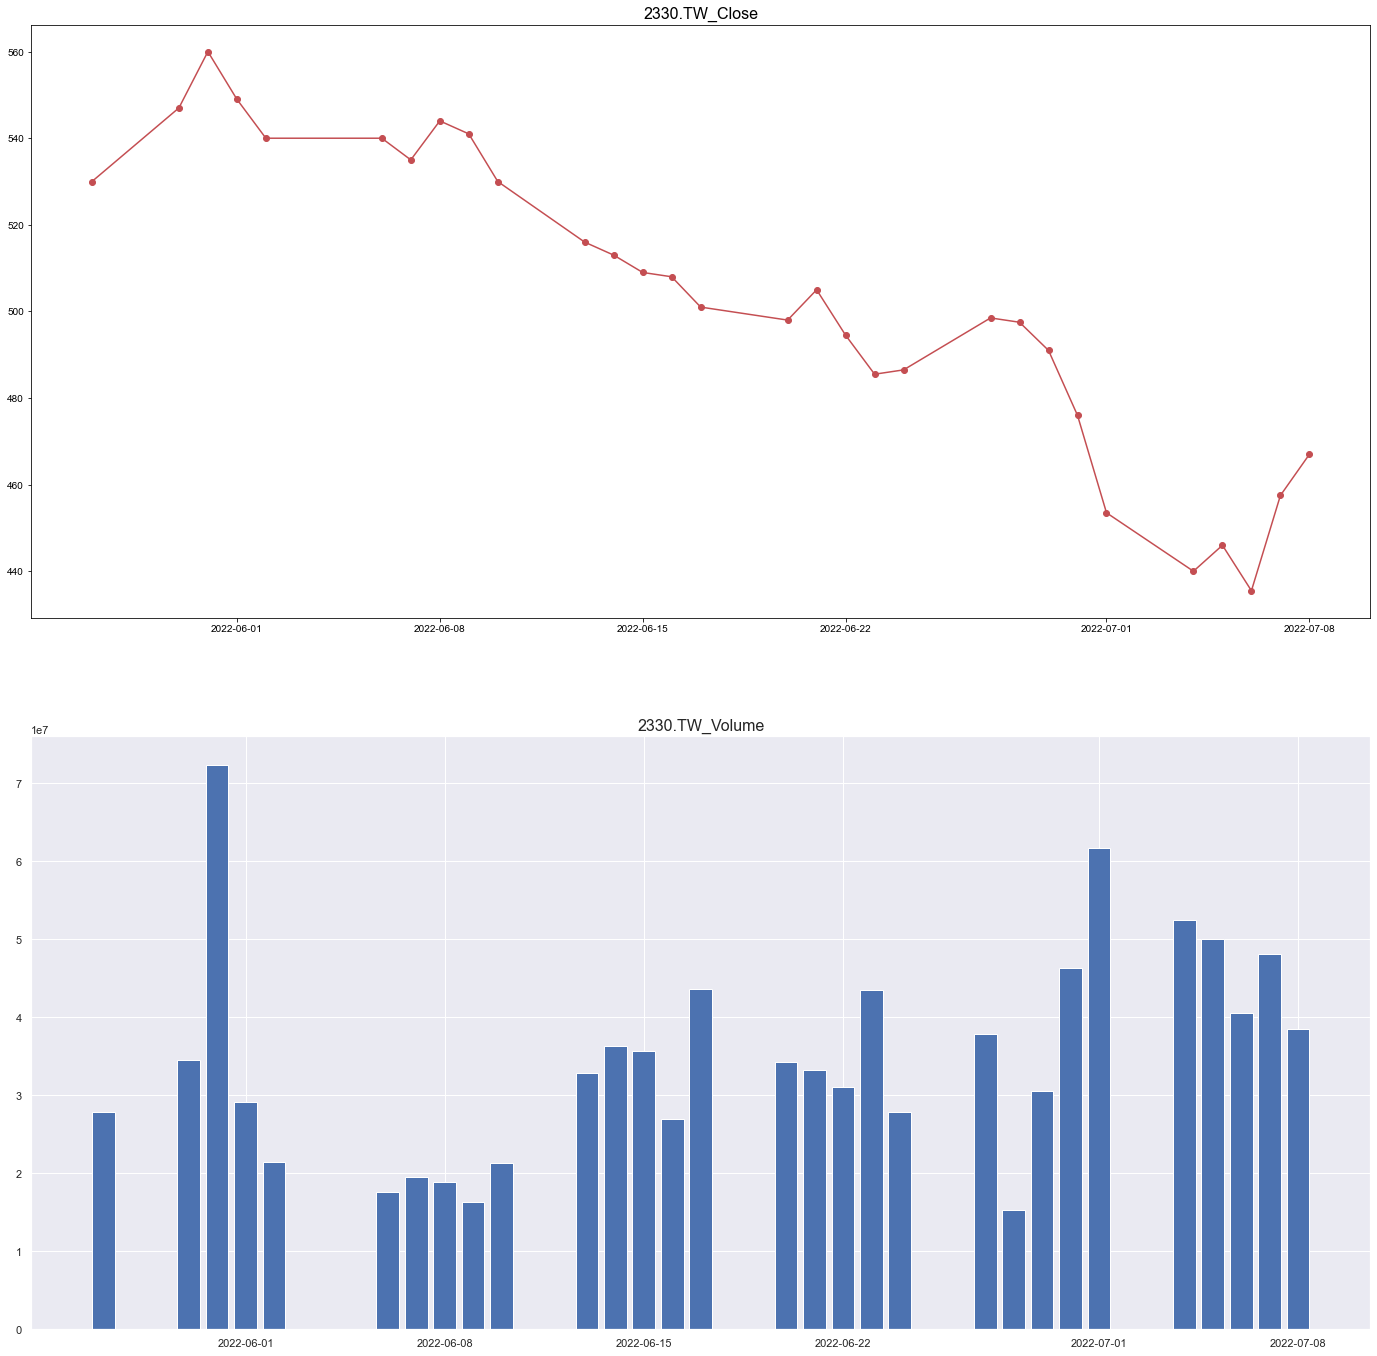

In [7]:
stock_draw(codes=['2330.TW'],day='')

In [8]:
import seaborn as sns
def stock_draw(codes=[],day=''):
    try:
        if day=='':
            day='30'
        if codes==[]:
            codes=stock_top()[1]
        for code in codes:
            print(code)
            prices = yf.download(
            f'{code}',
            # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            period = f'{day}d',
            progress=False
            )
            
            # 畫K線
            
            cf.set_config_file(world_readable=True,theme='pearl',offline=True)
            name=df_stockname.loc[df_stockname['symbol']==code.split('.')[0]]['name'].values[0]
            qf = cf.QuantFig(prices, title=f"{name}股票K線圖",legend='top', name='日K線圖')
            qf.add_volume()
            qf.add_sma(periods=5, column='High', color='#66ff66')
            qf.figure(up_color='#ff0000',down_color='#000000').iplot()
    except:
        print('此股票未上市或無此股票')


import pandas as pd
import yfinance as yf
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

df = yf.download('SPY',start='2019-01-01', end = '2020-04-20')

init_notebook_mode()
qf = cf.QuantFig(df, title='SPY Price', legend='top', name='SPY')
qf.add_volume()
qf.add_sma(periods=20, column='Close', color='red')
qf.add_ema(periods=20, color='green')

qf.iplot()

C:\Users\swill\AppData\Local\Temp\ipykernel_15768\4024124112.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  chrome=webdriver.Chrome(path,options=option)


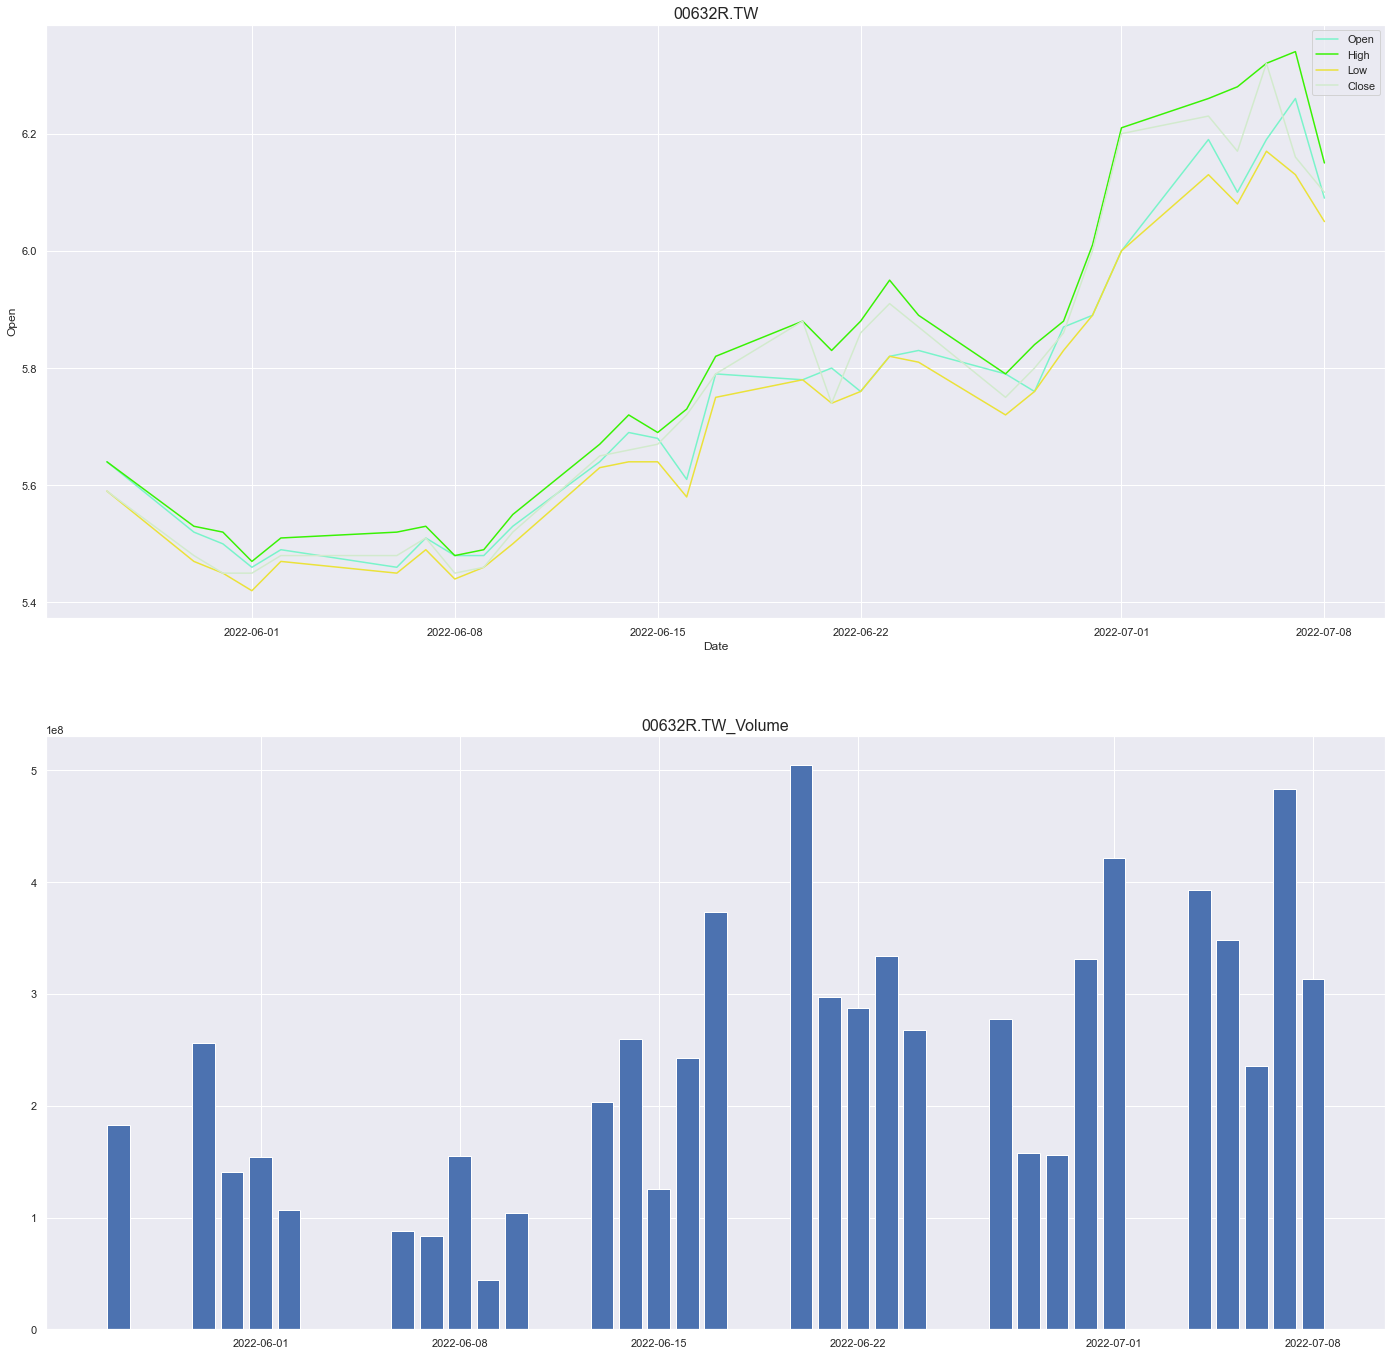

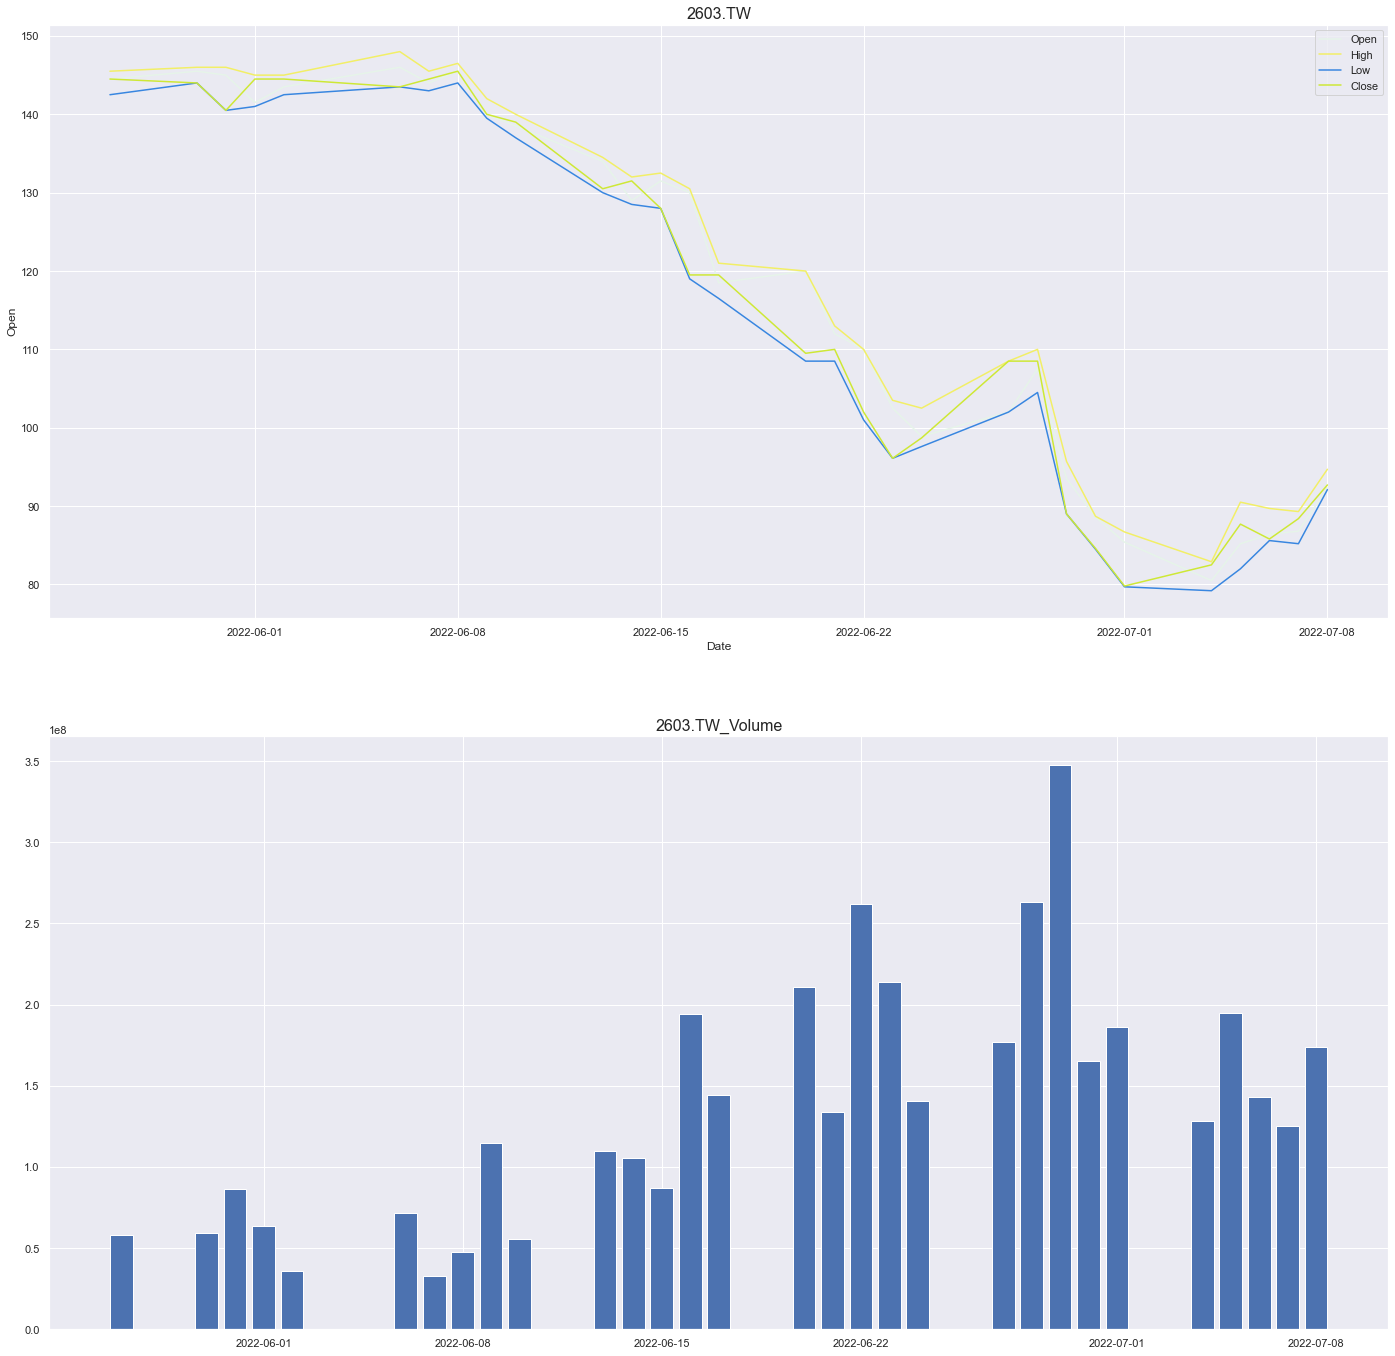

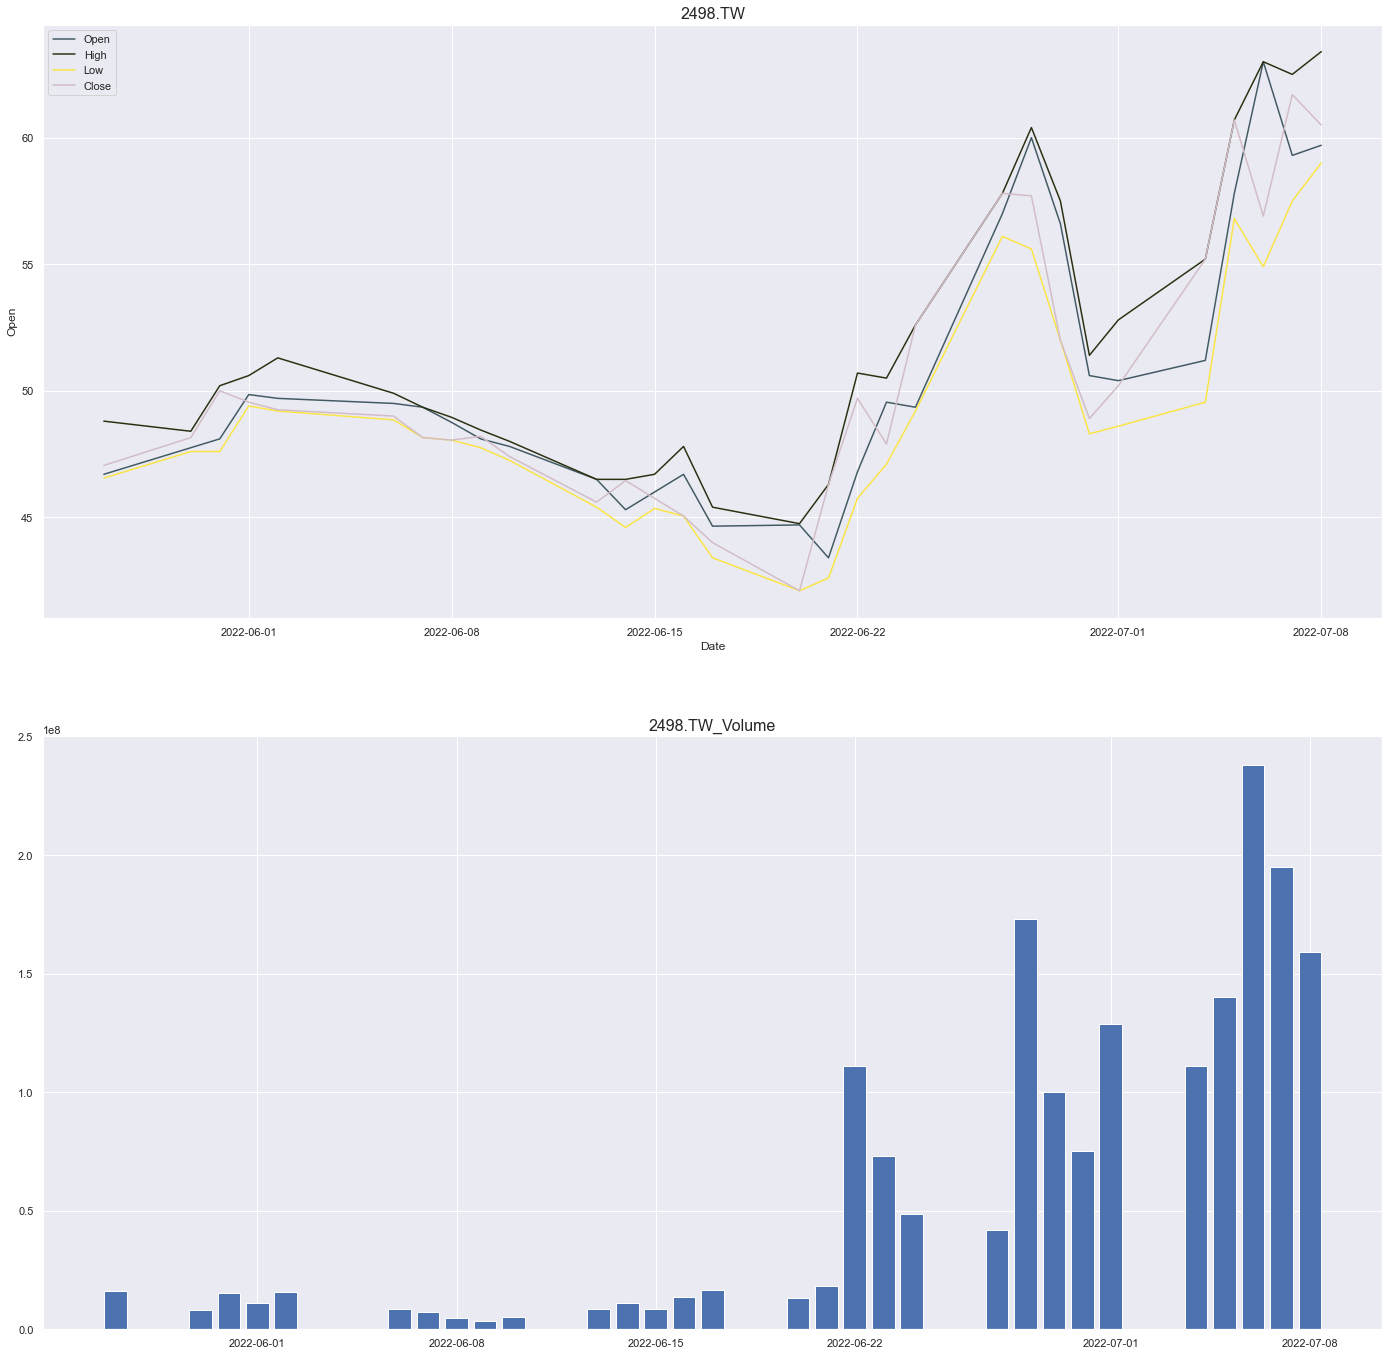

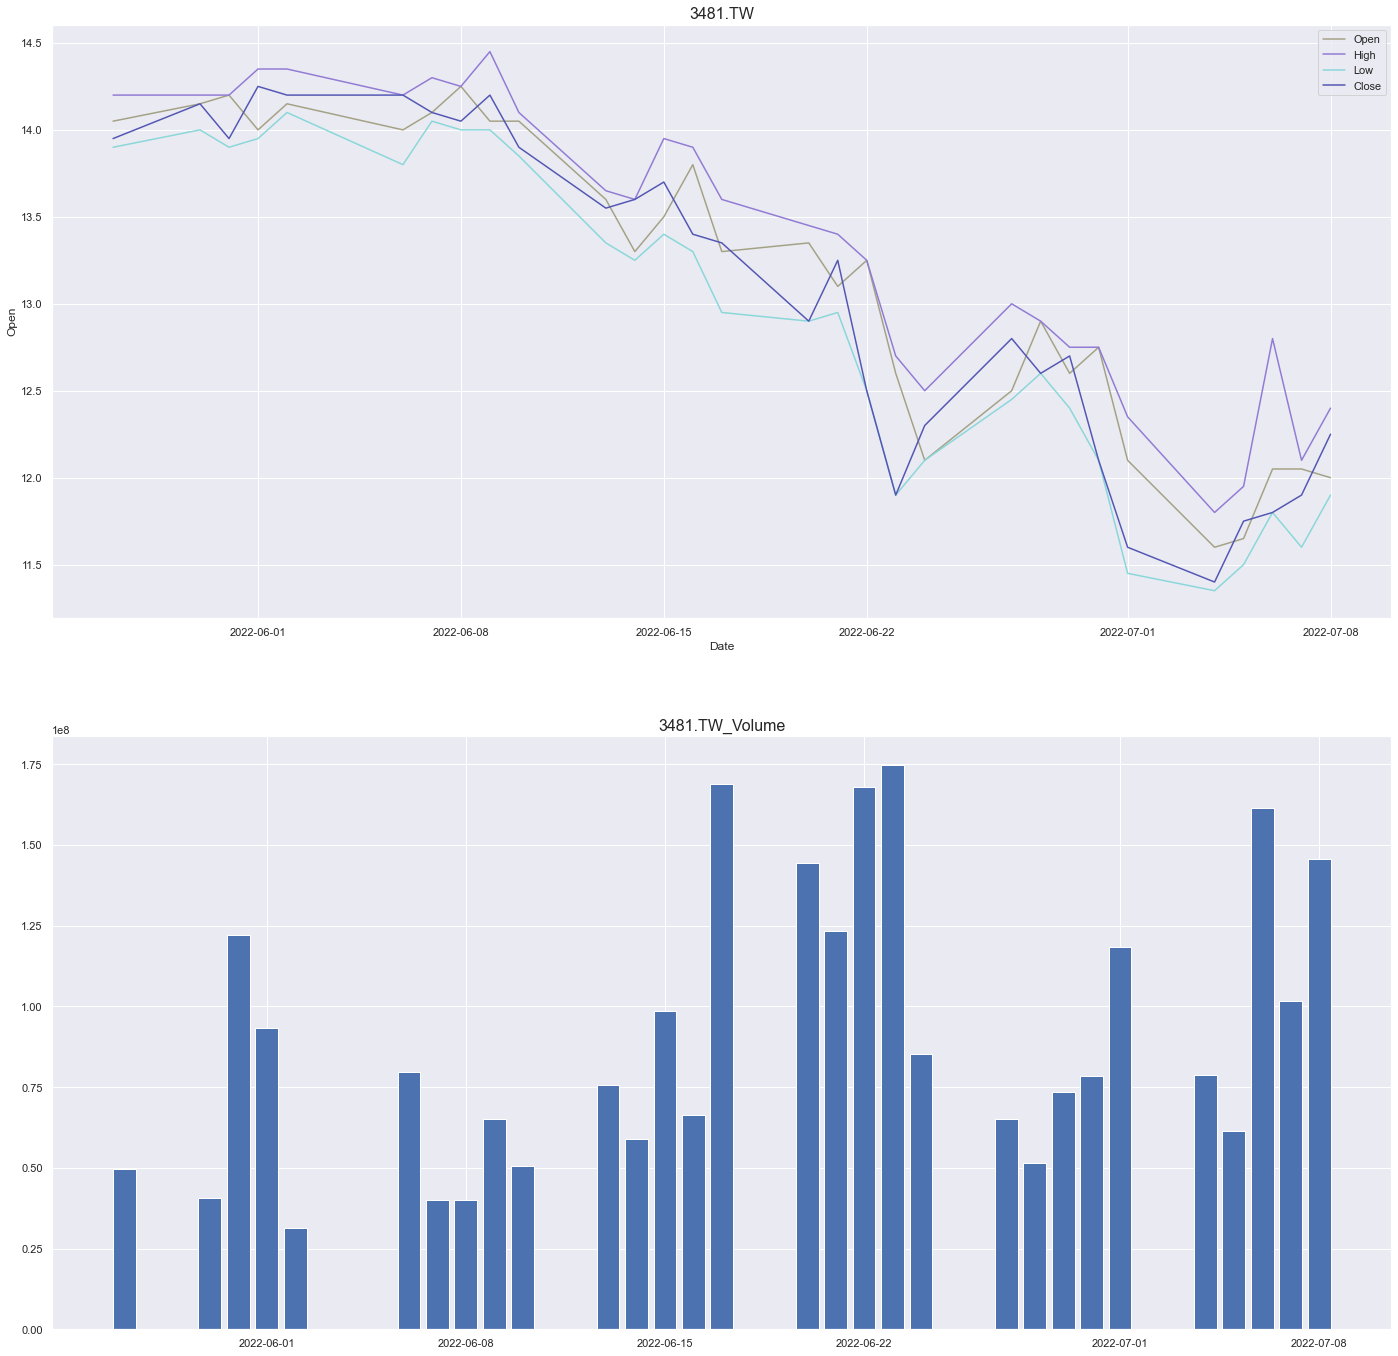

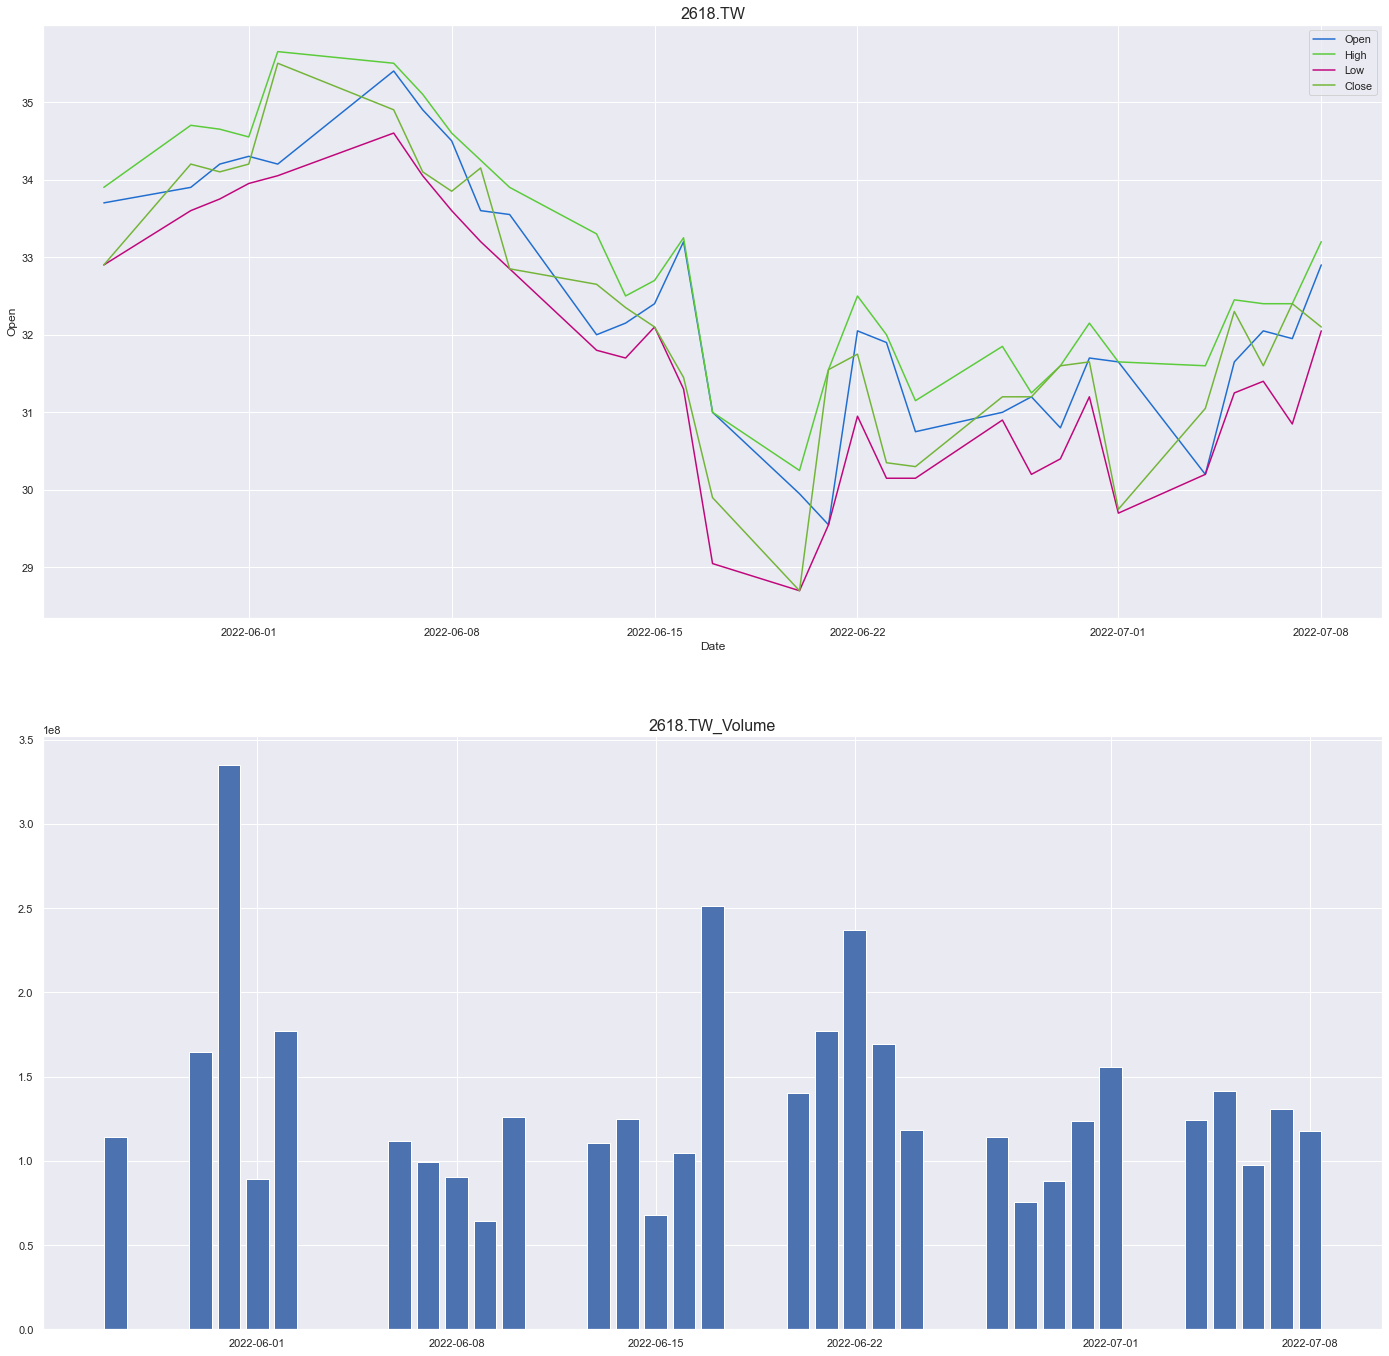

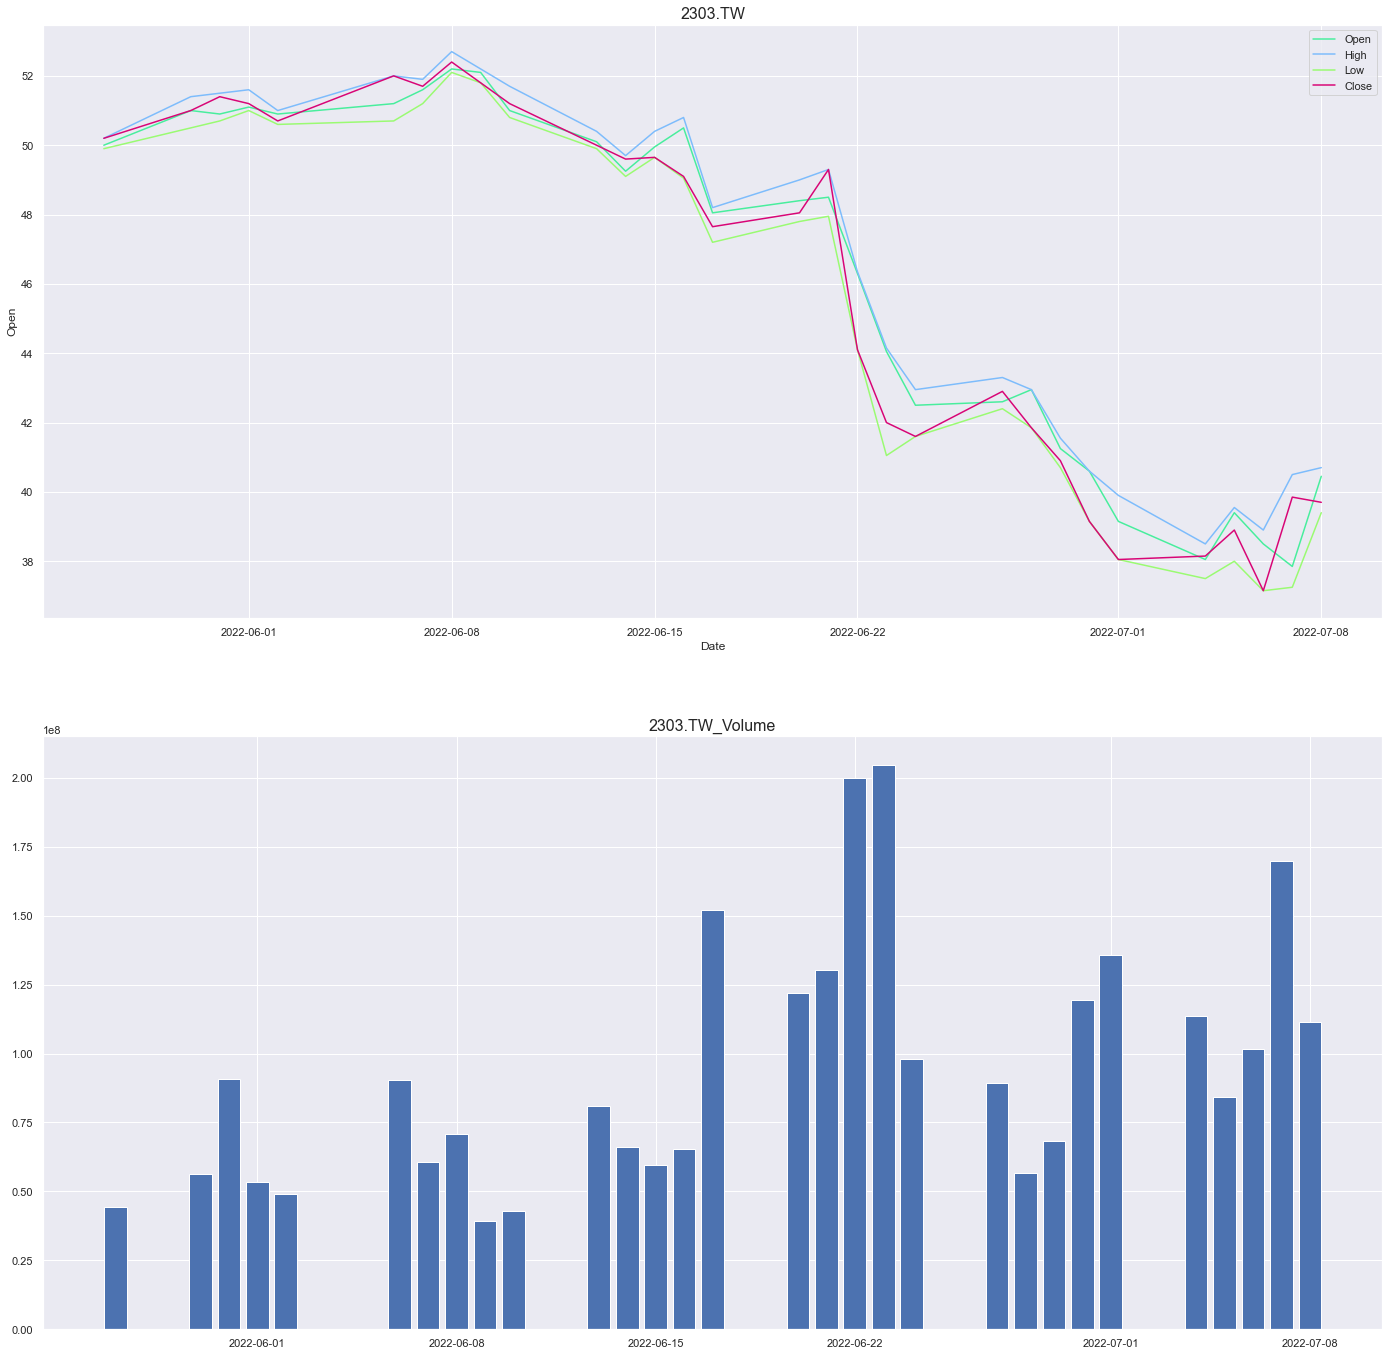

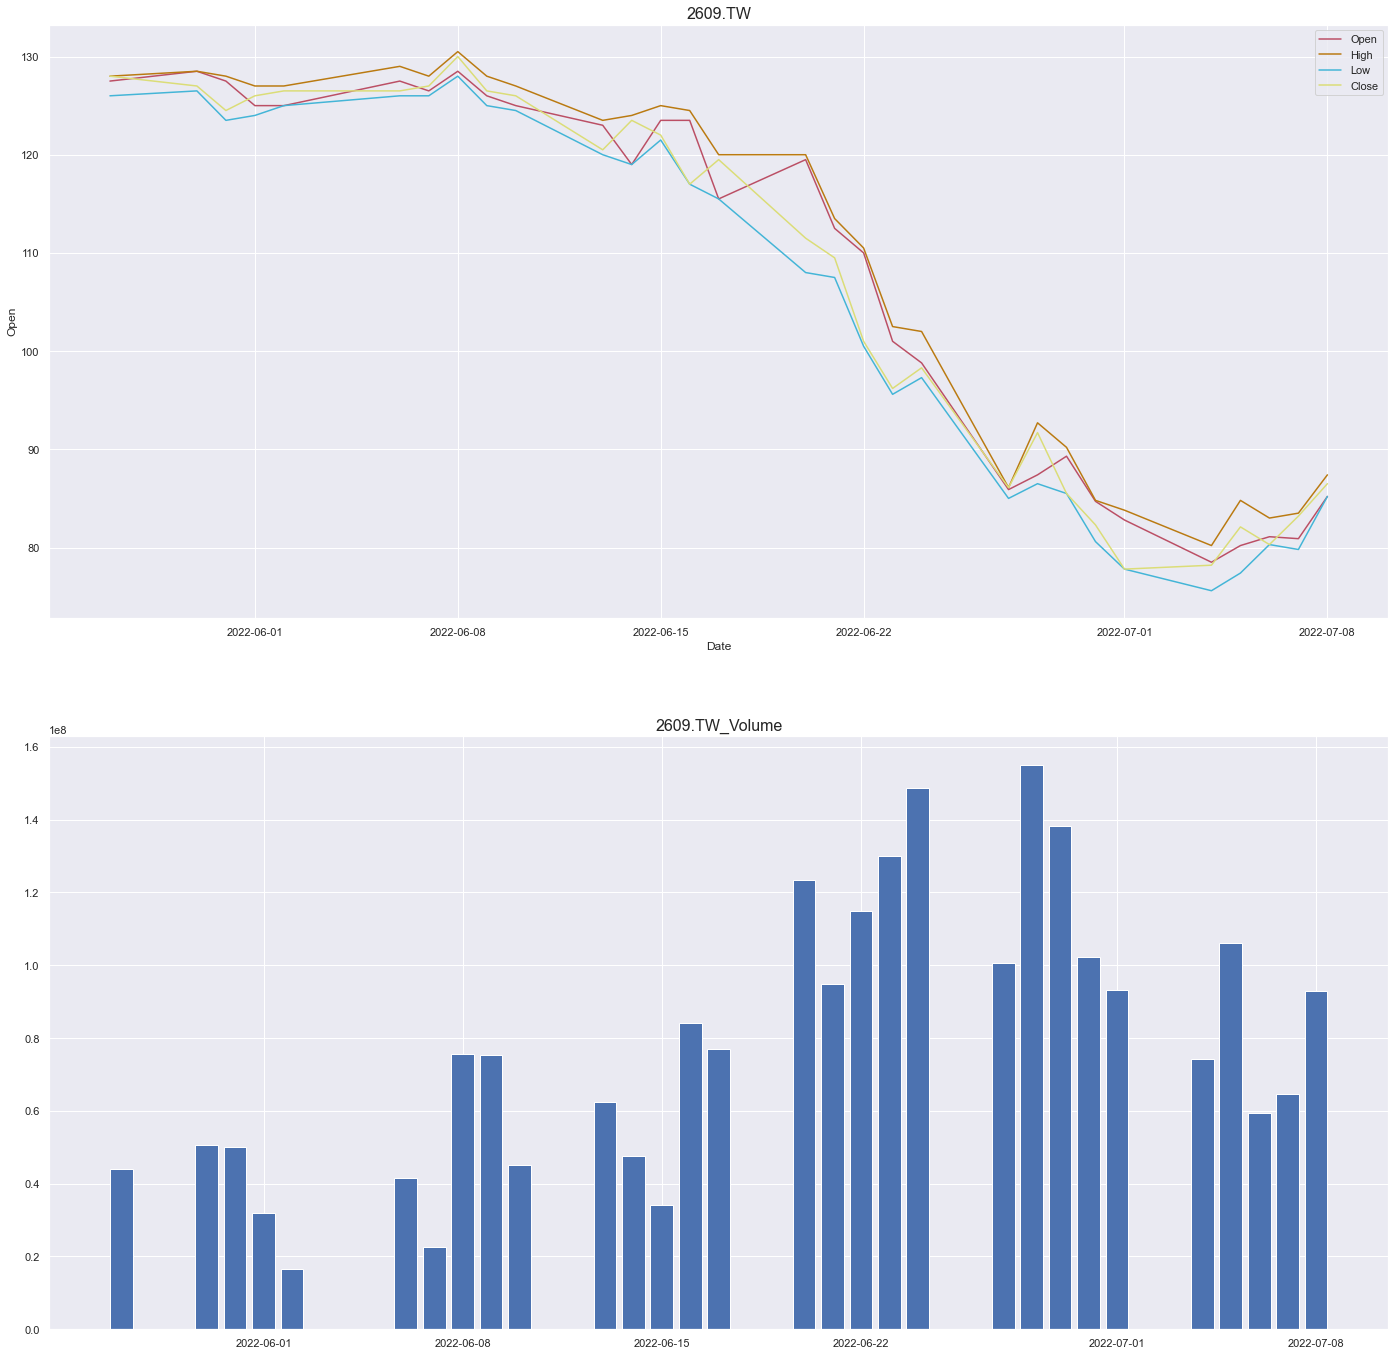

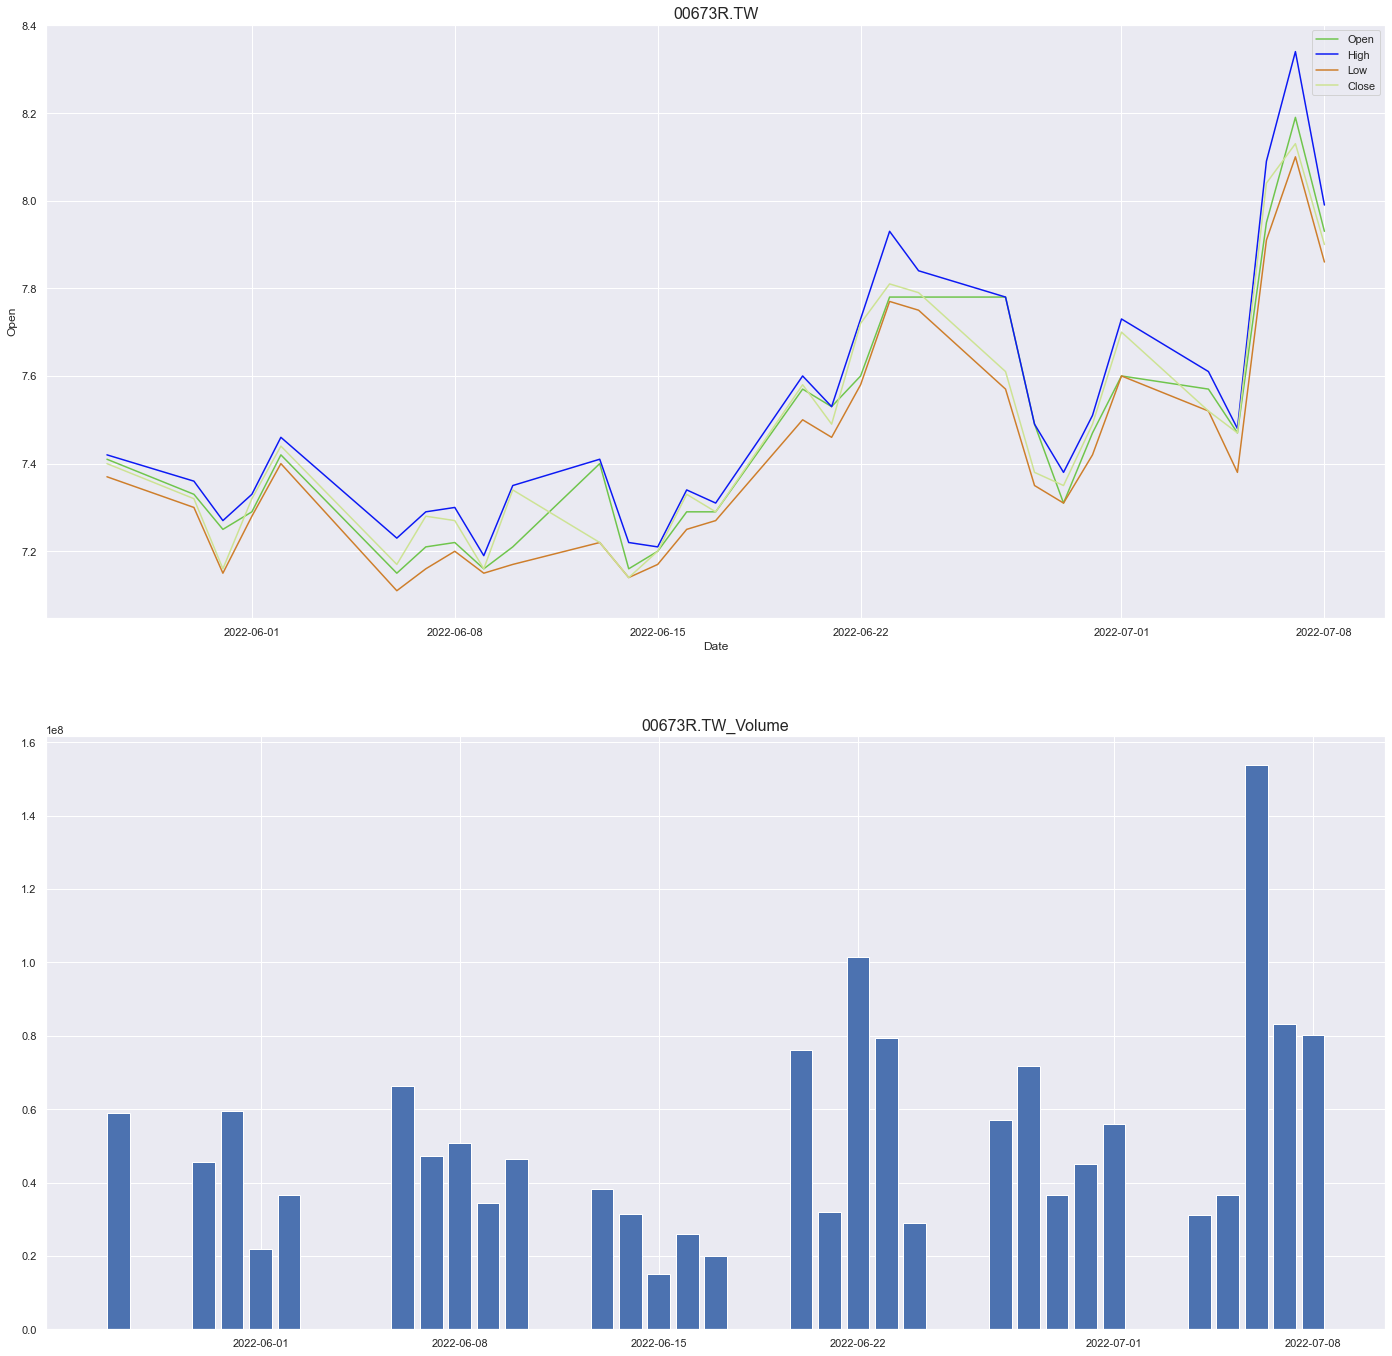

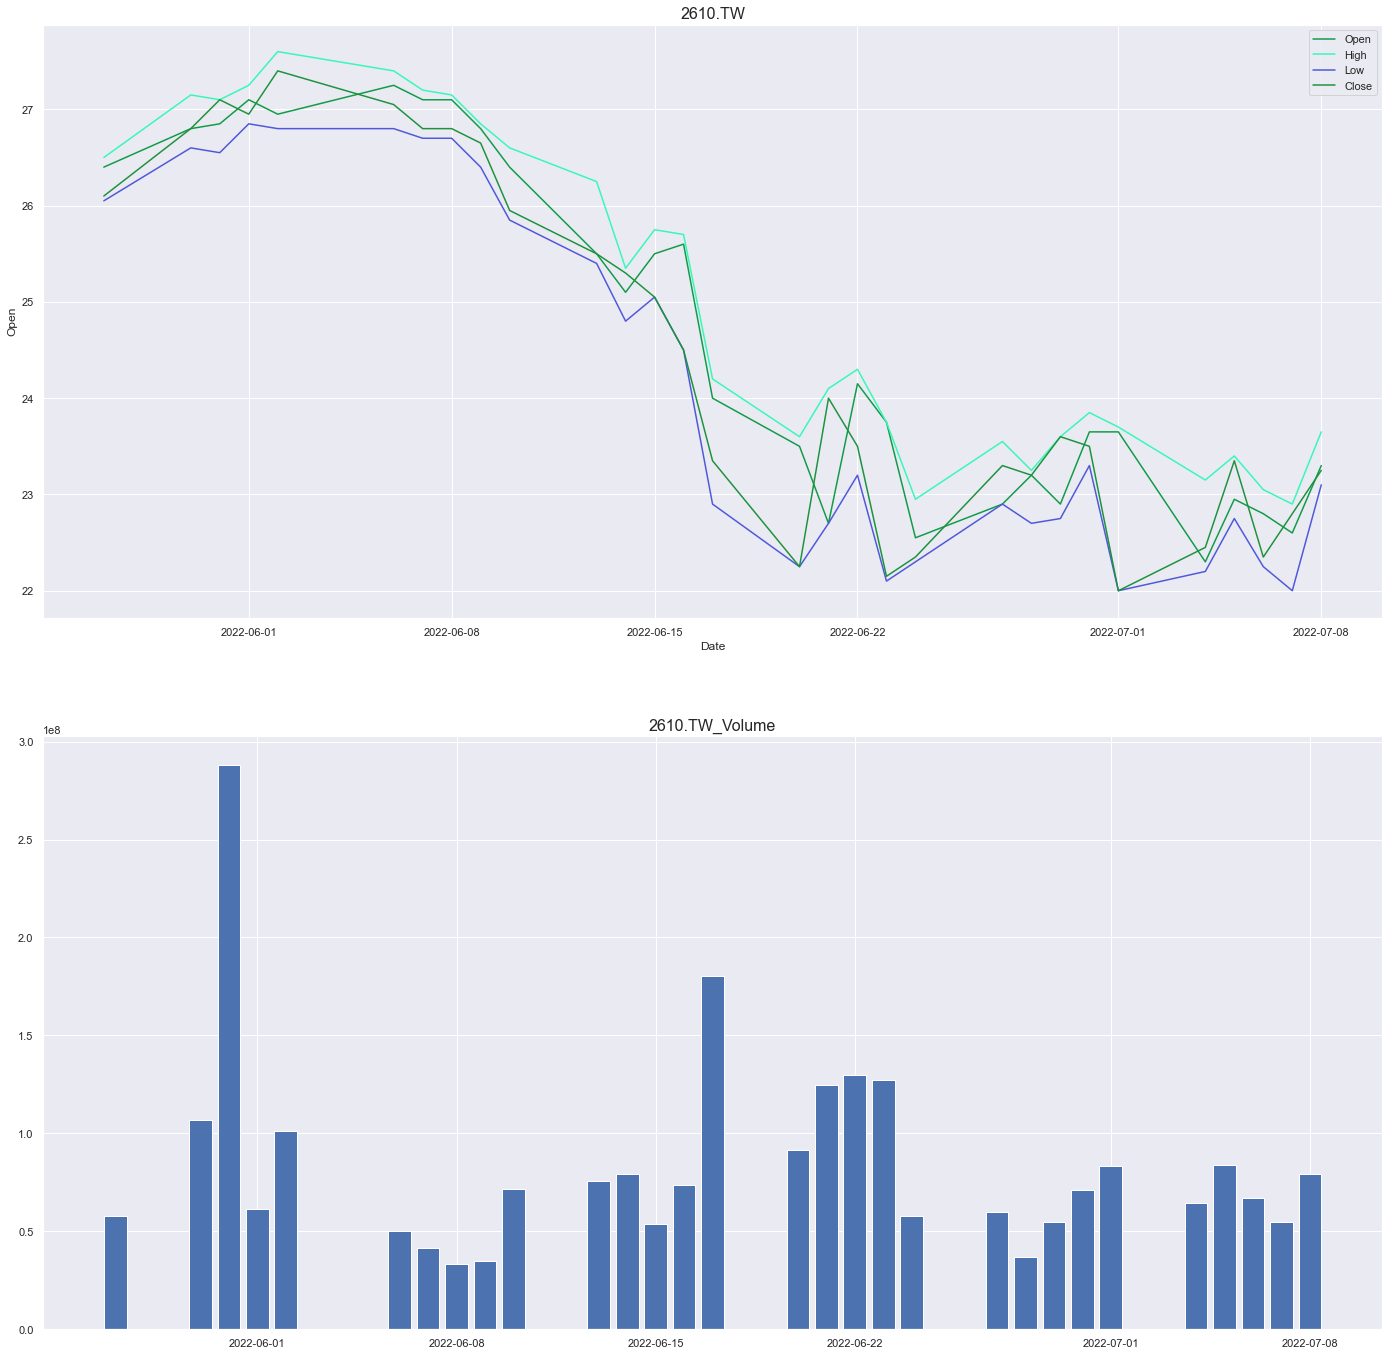

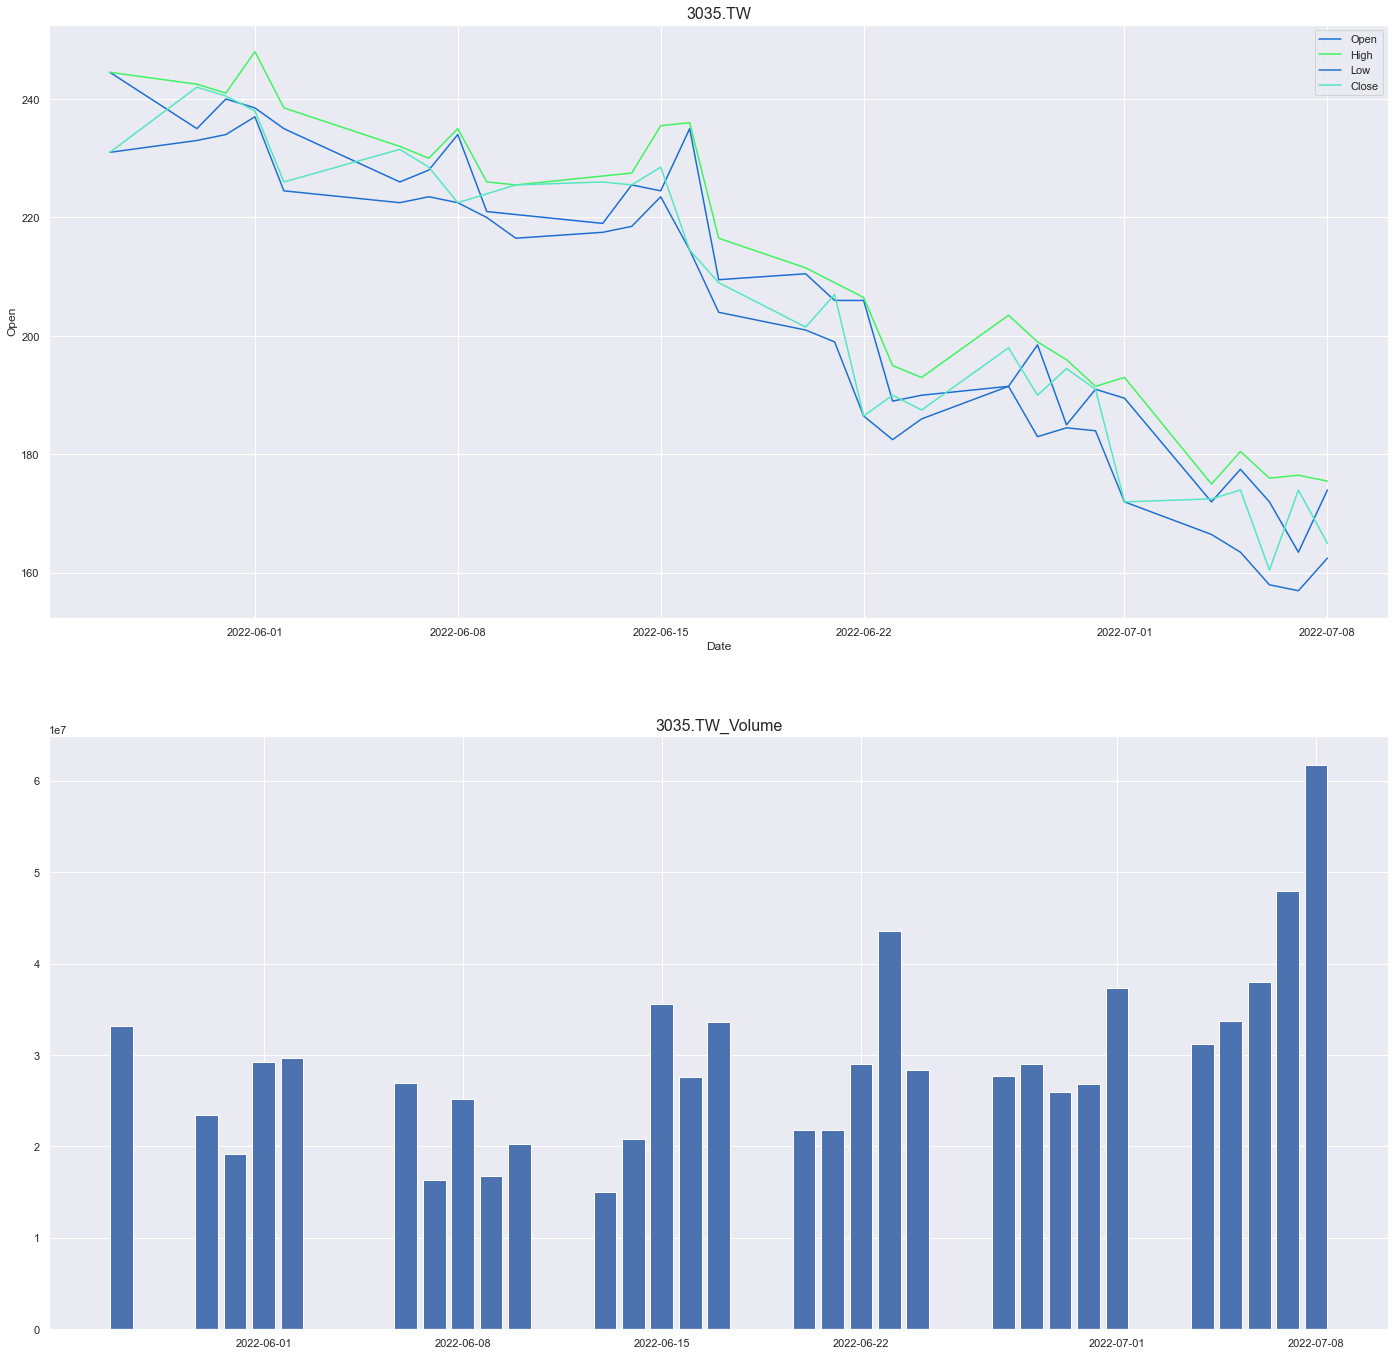

In [9]:

symbol=[]
day=''
name=""     


def Radiobutton_event(widget):
    global output
    choice  = radioValue.get()
    if choice:
        output=widget['text']
    return  output

def choose_stock():
    global output,symbol
    a = entry1.get()
    if  len(set(symbol))>3:
        tkinter.messagebox.showerror(title = "錯誤", message = '股票數超過四張') 
    elif a in df_stockname['symbol'].values :
        tkinter.messagebox.showinfo(title = '完成', message = "輸入成功") 
        symbol.append(f'{a}{output}')
        symbol=list(set(symbol))
        var.set(symbol)
    else:
        tkinter.messagebox.showerror(title = "錯誤", message = '資料庫無此號股票') 
        
def Clearstock():
    global symbol
    symbol=[]
    var.set(symbol)
    
def Delstock():
    global symbol
    try:
        symbol.remove(symbol[len(symbol)-1])
        var.set(symbol)
    except:
        tkinter.messagebox.showerror(title = "錯誤", message = '無股票') 
    
def show():
    global symbol,day
    try:
        if entry2.get()=='':
            day='30'
        else:
            day=int(entry2.get())
    except:
        tkinter.messagebox.showerror(title = "錯誤", message = '輸入錯誤') 
    
    if symbol==[]:
        symbol=stock_top()[1]
    for code in symbol:
        draw(code,day)
        plt.show()
        
def draw(code,day):
    global name
    prices = yf.download(
    f'{code}',
    # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    period = f'{day}d',
    progress=False
    )
    name=df_stockname.loc[df_stockname['symbol']==code.split('.')[0]]['name'].values[0]
    plt.figure(figsize=(24,24))
    plt.subplot(2,1,1)   
    colors = [("#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)]))for j in range(5)]
    for i,j in enumerate(prices.columns[:4]):
        sns.lineplot(x = prices.index, y = prices[f'{j}'], data = prices, color = colors[i])
    plt.legend(labels = prices.columns[:4])
    plt.title(f'{code}',fontsize=16)
    plt.subplot(2,1,2)
    plt.bar(prices.index,prices['Volume'])
    plt.title(f'{code}_Volume',fontsize=16)
    plt.show()

def save():
    global path,name,day,symbol
    path=entry3.get()
    if day=='':
        day='30'
    if symbol==[]:
        symbol=stock_top()[1]
    if path=='':
        path='.'
    for code in symbol:
        draw(code,day)
        try:
            os.mkdir(f'{path}\\img')
            plt.savefig(f'{path}\\img\\{name}.jpg')
        except FileExistsError:
            plt.savefig(f'{path}\\img\\{name}.jpg')
        except:
            tkinter.messagebox.showerror(title = "錯誤", message = '地址輸入錯誤') 

window = tk.Tk()
radioValue = tk.IntVar() 
var = tk.StringVar()

window.title('window')
window.geometry('300x300')
# 標示文字
label1 = tk.Label(window, text = '股票號數(最多四張,一次只能輸入一張)')
label2 = tk.Label(window, text = '註:如果空值顯示今日成交量前十股票')
entry1 = tk.Entry(window) # 輸入欄位的寬度
rdioOne =tk.Radiobutton(window, width=8, text='.TWO',variable=radioValue,value=1,command=lambda: Radiobutton_event(rdioOne)) 
rdioTwo =tk.Radiobutton(window, width=8, text='.TW',variable=radioValue,value=2,command=lambda: Radiobutton_event(rdioTwo)) 
label3 = tk.Label(window, textvariable=var, bg='white', fg='black', font=('Arial', 12), width=30,height=2)
button1 = tk.Button(window, width=10, text = "股票儲存", command = choose_stock)
button2 = tk.Button(window, width=10, text = "股票清空", command = Clearstock)
button3 = tk.Button(window, width=10, text = "刪除", command = Delstock)
label4 = tk.Label(window, text = '股票所需日數(天數,預設30天)')
entry2 = tk.Entry(window,width = 15) # 輸入欄位的寬度
button4 = tk.Button(window, text = "出圖", command =show,width =30)
label5 = tk.Label(window, text = '存圖位置')
entry3 = tk.Entry(window)
button5 = tk.Button(window, text = "存圖", command =save,width =30)

label1.pack()
label2.pack()
entry1.pack()
x1=50
rdioOne.place(x=x1+30,y=60)
rdioTwo.place(x=x1+100,y=60)
label3.place(x=15,y=90)
button1.place(x=5,y=140)
button2.place(x=x1+50,y=140)
button3.place(x=x1+150,y=140)
label4.place(x=0,y=170)
entry2.place(x=180,y=170)
button4.place(x=45,y=195)
label5.place(x=5,y=225)
entry3.place(x=65,y=225)
button5.place(x=45,y=250)

window.mainloop()

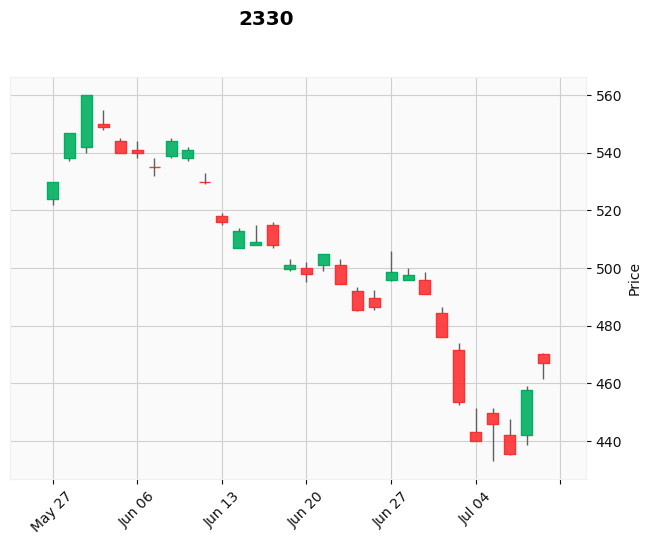

In [10]:
code='2330.TW'
day='30'
import mplfinance as mpf
prices = yf.download(
    f'{code}',
    # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    period = f'{day}d',
    progress=False
    )
mpf.plot(prices, type='candlestick', style='yahoo', title='2330')

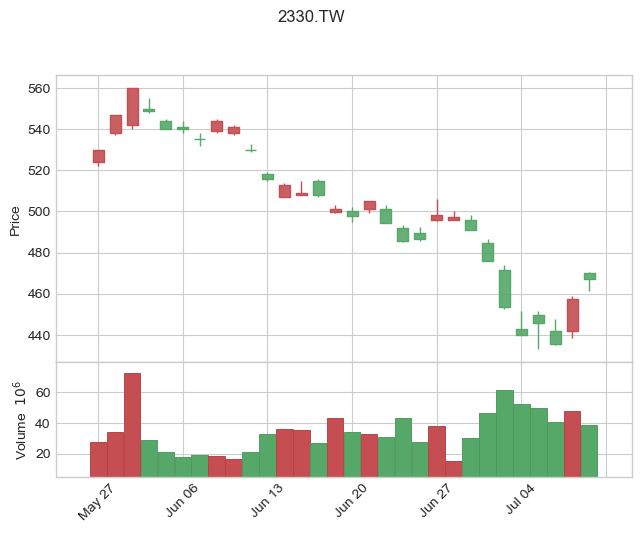

 磁碟區 C 中的磁碟是 OS
 磁碟區序號:  16BD-925F

 C:\Users\swill\Downloads 的目錄


 C:\Users\swill\Downloads 的目錄



找不到檔案


FileNotFoundError: [Errno 2] No such file or directory: 'tsave100.jpg'

In [14]:
import IPython.display as IPydisplay
prices = yf.download(
    f'{code}',
    # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    period = f'{day}d',
    progress=False
    )
name=df_stockname.loc[df_stockname['symbol']==code.split('.')[0]]['name'].values[0]
mc = mpf.make_marketcolors(up='r',
                           down='g',
                           edge='',
                           wick='inherit',
                           volume='inherit')

s = mpf.make_mpf_style(base_mpl_style='seaborn-whitegrid', marketcolors=mc)
mpf.plot(prices, type='candle',title=f'{code}', style=s, volume=True)
%ls -l testsave.png
IPydisplay.Image(filename='tsave100.jpg')

In [12]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False